<a href="https://colab.research.google.com/github/fiveace-Merill/data-anonymization/blob/main/data_anonymization_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATA ANONYMIZATION TECHNIQUES IMPLEMENTATIONS**

In [ ]:
from google.colab import drive

# Mount the new drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import timeit
import base64
import torch
import faker
import random
import json
import hashlib
from datetime import datetime
from cryptography.fernet import Fernet

# Load your health dataset from a CSV file
patient_data = pd.read_csv('/content/drive/MyDrive/data-anonymization/data/csv/input_data/patients_REH.csv')
careplan_data = pd.read_csv('/content/drive/MyDrive/data-anonymization/data/csv/input_data/careplans_REH.csv')

original_size = (os.path.getsize('/content/drive/MyDrive/data-anonymization/data/csv/input_data/patients_REH.csv')) / 1000000

In [ ]:
def get_file_size(file_path):
    file_size = (os.path.getsize(file_path)) / 1000000
    return file_size

## 1. Generalization

In [ ]:
sensitive_fields = ['BIRTHDATE']
def generalize_data(data, fields_to_generalize):
  generalized_data = data.copy()
  for field in fields_to_generalize:
    if field in generalized_data.columns:
      if field == 'FIRST' or field == 'LAST':
        mask_data(generalized_data, field)
      elif field == 'LAST':
        mask_data(generalized_data, field)
      elif field == 'BIRTHDATE':
        def calculate_age(birthdate_str):
          # Assuming birthdate_str is in the format MM/DD/YY
          birthdate = datetime.strptime(birthdate_str, '%m/%d/%y')
          # Get the birth year from the datetime object
          birth_year = birthdate.year
          # Determine the assumed century based on the two-digit year
          if birth_year > 2023:
            assumed_century = 1900
            sentinel = birth_year - 2000
          else:
            assumed_century = 2000
            sentinel = birth_year - 2000
          # Create a new datetime object with the correct year
          adjusted_birthdate = datetime(assumed_century + sentinel, birthdate.month, birthdate.day)
          # Calculate age correctly by subtracting birth year from the current year
          age = datetime.now().year - adjusted_birthdate.year
          return age
        generalized_data['AGE'] = generalized_data[field].apply(lambda x: calculate_age(x))
        def generalize_age(age_series):
          # Replace this with your own calculation logic
          # For example, you can replace each age with a rounded value or a specific category
          age_groups = ['<20', '20-35', '36-50', '51+']
          generalized_values = pd.cut(age_series, bins=[0, 20, 35, 50, float('inf')], labels=age_groups)
          return generalized_values
        generalized_data['AGE'] = generalize_age(generalized_data['AGE'])
      else:
        print("Add Statement")
      generalized_data = generalized_data.drop('BIRTHDATE', axis=1)
    return generalized_data
# Generalize the data
generalized_data = generalize_data(patient_data, sensitive_fields)

# Generalize the data
generalization_time = timeit.timeit(lambda: generalize_data(patient_data, sensitive_fields), number=10)

print(f'Generalization Time: {generalization_time} seconds')

# Save the generalized data to a new CSV file
output_file = '/content/drive/MyDrive/data-anonymization/data/csv/output_data/generalized_health_data.csv'
generalized_data.to_csv(output_file, index=False)

generalization_file_size = get_file_size('/content/drive/MyDrive/data-anonymization/data/csv/output_data/generalized_health_data.csv')

Generalization Time: 0.29019529299998226 seconds


## 2.Pertubation

In [ ]:
start_time, end_time = 0, 0
# Define the fields you want to perturb
sensitive_fields = ['SSN','FIRST','LAST','ADDRESS']

# Define the perturbation function
def perturb_data(data, fields_to_perturb, epsilon=1.0):
    perturbed_data = data.copy()
    for field in fields_to_perturb:
      if field in perturbed_data.columns:
        # Perturb numerical fields by adding Laplace-distributed noise
        noise = np.random.laplace(scale=1.0 / epsilon, size=len(perturbed_data))
        def insert(main_string, insert_string):
          random_position = random.randint(0, len(main_string))
          result_string = main_string[:0] + main_string[int(len(main_string)/2):]
          result_string = ''.join(insert_string)
          return result_string
        perturbed_data[field] = perturbed_data[field].apply(lambda x: insert(str(x), str(noise)))
      else:
        print('Invalid column Name')
    return perturbed_data
#Pertubation time
perturbed_time = timeit.timeit(lambda: perturb_data(patient_data, sensitive_fields), number=10)

# Save the perturbed data to a new CSV file
perturbed_data = perturb_data(patient_data, sensitive_fields)
perturbed_data.to_csv('/content/drive/MyDrive/data-anonymization/data/csv/output_data/perturbed_health_data.csv', index=False)

#Get the resutting file size
perturbed_file_size = get_file_size('/content/drive/MyDrive/data-anonymization/data/csv/output_data/perturbed_health_data.csv')

## 3.Data Masking

In [ ]:
# Define the fields you want to mask
sensitive_fields = ['FIRST', 'LAST', 'SSN', 'ADDRESS']

# Define the masking function
def mask_data(data, fields_to_mask):
    masked_data = data.copy()
    for field in fields_to_mask:
        if field in masked_data.columns:
            masked_data[field] = '*****'
    return masked_data
#Get Execution time
masking_time = timeit.timeit(lambda: mask_data(patient_data, sensitive_fields), number = 10)


# Save the masked data to a new CSV file
masked_data = mask_data(patient_data, sensitive_fields)
masked_data.to_csv('/content/drive/MyDrive/data-anonymization/data/csv/output_data/masked_health_data.csv', index=False)

#Get file size
masked_file_size = get_file_size('/content/drive/MyDrive/data-anonymization/data/csv/output_data/masked_health_data.csv')


## 4.Data Pseudonymization

In [ ]:
# Define the fields you want to pseudonymize
sensitive_fields = ['FIRST','LAST','SSN', 'ADDRESS']

# Define the pseudonymization function
def pseudonymize_data(data, fields_to_pseudonymize):
    pseudonymized_data = data.copy()
    # Store the mapping between pseudonyms and original data
    pseudonymization_map = {}
    for field in fields_to_pseudonymize:
        if field in pseudonymized_data.columns:
            # Generate pseudonyms and create a mapping
            pseudonymized_data[field] = pseudonymized_data[field].apply(lambda x: f'Pseudonym_{hash(x)}')
            pseudonymization_map[field] = dict(zip(data[field], pseudonymized_data[field]))
    return pseudonymized_data, pseudonymization_map
#Get Execution time
pseudonymization_time = timeit.timeit(lambda: pseudonymize_data(patient_data, sensitive_fields), number = 10)

# Save the pseudonymized data to a new CSV file
pseudonymized_data, pseudonymization_map = pseudonymize_data(patient_data, sensitive_fields)
pseudonymized_data.to_csv('/content/drive/MyDrive/data-anonymization/data/csv/output_data/pseudonymized_health_data.csv', index=False)

#Get file size
pseudonymization_file_size = get_file_size('/content/drive/MyDrive/data-anonymization/data/csv/output_data/pseudonymized_health_data.csv')

# Save the pseudonymization map to a file for future reference
with open('/content/drive/MyDrive/data-anonymization/data/csv/output_data/pseudonymization_map.json', 'w') as map_file:
    json.dump(pseudonymization_map, map_file)

## 5.Data Swapping

In [ ]:
# Define the fields you want to swap
# FIRST', 'LAST
sensitive_fields = ['SSN', 'FIRST', 'LAST', 'ADDRESS']

# Define the data swapping function
def swap_data(data, fields_to_swap):
    swapped_data = data.copy()

    for field in fields_to_swap:
        if field in swapped_data.columns:
            unique_values = swapped_data[field].unique()
            random.shuffle(unique_values)
            # Create a mapping between original values and shuffled values
            value_mapping = dict(zip(unique_values, random.sample(list(unique_values), len(unique_values))))
            # Apply the mapping to swap values
            swapped_data[field] = swapped_data[field].map(value_mapping)
        else:
          print('Invalid Column Name')
    return swapped_data

#Get Execution time
swapped_time = timeit.timeit(lambda: swap_data(patient_data, sensitive_fields), number=10)

# Save the swapped data to a new CSV file
swapped_data = swap_data(patient_data, sensitive_fields)
swapped_data.to_csv('/content/drive/MyDrive/data-anonymization/data/csv/output_data/swapped_health_data.csv', index=False)

#Get file size
swapped_file_size = get_file_size('/content/drive/MyDrive/data-anonymization/data/csv/output_data/swapped_health_data.csv')

## 6.Noise Addition

In [ ]:
# Define the fields you want to add noise to
sensitive_fields = ['FIRST', 'LAST', 'SSN', 'ADDRESS']

# Define the noise addition function
def add_noise_to_data(data, fields_to_add_noise, epsilon=1.0):
    noisy_data = data.copy()
    for field in fields_to_add_noise:
        if field in noisy_data.columns:
            # Add Laplace-distributed noise with the specified privacy parameter (epsilon)
            def insert_at_random_position(main_string, insert_string):
              # Generate a random position within the length of the main string
              random_position = random.randint(0, int(len(main_string)/2))
              # Insert the insert_string at the random position
              result_string = main_string[:0] + main_string[int(len(main_string)/2):] + insert_string
              return result_string
            scale = 1.0 / epsilon
            noisy_data[field] = noisy_data[field].apply(lambda x: insert_at_random_position(str(x),str(np.random.laplace(0, scale, size=len(noisy_data)))))
        else:
          print('Invalid Column Name')
    return noisy_data

#Get time it takes to add noise to data
noise_addition_time = timeit.timeit(lambda: add_noise_to_data(patient_data, sensitive_fields), number=10)

# Save the noisy data to a new CSV file
noisy_data = add_noise_to_data(patient_data, sensitive_fields)
noisy_data.to_csv('/content/drive/MyDrive/data-anonymization/data/csv/output_data/noisy_health_data.csv', index=False)

#Get file size
noise_addition_file_size = get_file_size('/content/drive/MyDrive/data-anonymization/data/csv/output_data/noisy_health_data.csv')


## 7.Data Encryption

In [ ]:
sensitive_fields = ['FIRST','LAST','SSN', 'ADDRESS']
def encrypt_data(file_path, fields_to_mask):
    # Load the CSV file into a DataFrame
    encrypted_data = patient_data.copy()

    # Generate a single key for all sensitive fields
    key = Fernet.generate_key()
    cipher = Fernet(key)

    # Encrypt sensitive fields
    for field in fields_to_mask:
        if field in encrypted_data.columns:
            encrypted_data[field] = encrypted_data[field].astype(str)
            encrypted_data[field] = encrypted_data[field].apply(lambda x: cipher.encrypt(x.encode()).decode())
        else:
            print(encrypted_data[field])
            print(f'{field} is not a valid column name')

    return encrypted_data
#Get Encryption time
encryption_time = timeit.timeit(lambda: encrypt_data(patient_data, sensitive_fields), number=10)

# Save the masked data to a new CSV file
encrypted_data = encrypt_data(patient_data, sensitive_fields)
encrypted_data.to_csv('/content/drive/MyDrive/data-anonymization/data/csv/output_data/encrypted_health_data.csv', index=False)
encryption_file_size = get_file_size('/content/drive/MyDrive/data-anonymization/data/csv/output_data/encrypted_health_data.csv')



## 8.Synthetic Data

In [ ]:
#Reset timing variables
start_time, end_time = 0, 0
# Initialize the Faker library to generate fake names, addresses, and other details
fake = faker.Faker()
def generate_synthetic_data(num_records):
    data = {
        'ID': [fake.uuid4() for _ in range(num_records)],
        'SSN': [fake.ssn() for _ in range(num_records)],
        'FIRST': [fake.first_name() for _ in range(num_records)],
        'LAST': [fake.last_name() for _ in range(num_records)],
        'BIRTHDATE': [fake.date_of_birth(minimum_age=18, maximum_age=100) for _ in range(num_records)],
        'ADDRESS': [fake.address() for _ in range(num_records)],
        'GENDER': [fake.random_element(elements=('M', 'F')) for _ in range(num_records)]
    }
    return pd.DataFrame(data)

num_records = len(patient_data)  # Adjust the number of records as needed

#Get time it takes to generate synthetic data
synthetic_time = timeit.timeit(lambda: generate_synthetic_data(num_records), number=10)

#Get the file size of the synthetic data generated
synthetic_data = generate_synthetic_data(num_records)
synthetic_data.to_csv('/content/drive/MyDrive/data-anonymization/data/csv/output_data/synthetic_health_data.csv', index=False)
original_data = patient_data.copy()
combined_data = pd.concat([original_data, synthetic_data], axis=1)
combined_data.to_csv('/content/drive/MyDrive/data-anonymization/data/csv/output_data/combined_health_data.csv', index=False)
synthetic_file_size = get_file_size('/content/drive/MyDrive/data-anonymization/data/csv/output_data/combined_health_data.csv')

## 9.Data Tokenization

In [ ]:
# Function to generate tokens
def tokenize_data(data, fields_to_tokenize):
    faker_generator = faker.Faker()
    token_dict = {}
    for field in fields_to_tokenize:
        if field in data.columns:
            # Generate unique tokens for each unique value in the column
            unique_values = data[field].unique()
            tokens = [Fernet.generate_key().decode() for _ in range(len(unique_values))]
            token_dict[field] = dict(zip(unique_values, tokens))

            # Apply tokenization to the column
            data[field] = data[field].map(token_dict[field])
        else:
            print(f'{field} is not a valid column name')
    return data, token_dict

# Function to anonymize data
def anonymize_data(data, fields_to_anonymize):
    for field in fields_to_anonymize:
        if field in data.columns:
            # Replace the actual values with anonymized values
            data[field] = data[field].apply(lambda x: hashlib.sha256(str(x).encode()).hexdigest())
        else:
            print(f'{field} is not a valid column name')
    return data

# Define columns to tokenize and anonymize
fields_to_tokenize = ['SSN','FIRST','LAST','ETHNICITY']
fields_to_anonymize = ['SSN','FIRST','LAST','ADDRESS',]
def timing_abstraction(data):
  # Tokenize specified columns
  data, token_dict = tokenize_data(data, fields_to_tokenize)
  # Anonymize specified columns
  patient_data = anonymize_data(data.copy(), fields_to_anonymize)

# Save the tokenized and anonymized data to a new CSV file
patient_data.to_csv('/content/drive/MyDrive/data-anonymization/data/csv/output_data/tokenized_anonymized_data.csv', index=False)

#Get Tokenization time
tokenization_time = timeit.timeit(lambda: timing_abstraction(patient_data), number=10)

#Get Tokenized file size
tokenization_file_size = get_file_size('/content/drive/MyDrive/data-anonymization/data/csv/output_data/tokenized_anonymized_data.csv')


## Analysis

#### 1. Space Analysis

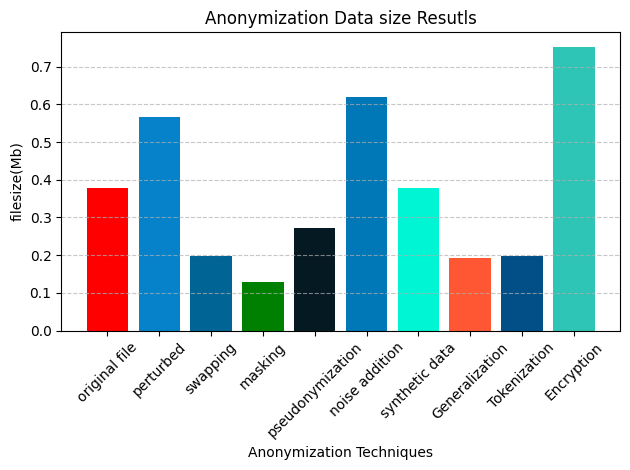

In [ ]:
anonymized_files_size = {
    "original file": synthetic_file_size,
    "perturbed": perturbed_file_size,
    "swapping": swapped_file_size,
    "masking": masked_file_size ,
    "pseudonymization": pseudonymization_file_size,  # Corrected typo here
    "noise addition": noise_addition_file_size,
    "synthetic data": synthetic_file_size,
    "Generalization": generalization_file_size,
    "Tokenization": tokenization_file_size,
    "Encryption": encryption_file_size
}
# Use a different color for "synthetic data"
colors = ['red', '#0582CA', '#006494', 'green', '#051923', '#0077b6', '#00F5D4', '#FF5733', '#014F86', '#2EC4B6']

plt.bar(anonymized_files_size.keys(), anonymized_files_size.values(), color=colors, linewidth=2)
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('filesize(Mb)')
plt.xlabel('Anonymization Techniques')
plt.title('Anonymization Data size Resutls')
plt.tight_layout()  # Adjust layout for better display
plt.savefig('/content/drive/MyDrive/data-anonymization/plots/data-size-plot.png')

<br><br>

#### 2.Time Analysis

dict_values([16.410989176000015, 0.6260051239999882, 0.056839795000001914, 0.15840746500001046, 12.700128741000015, 5.6551074569999855, 0.29019529299998226, 0.4295581259999892, 6.286714947999997])


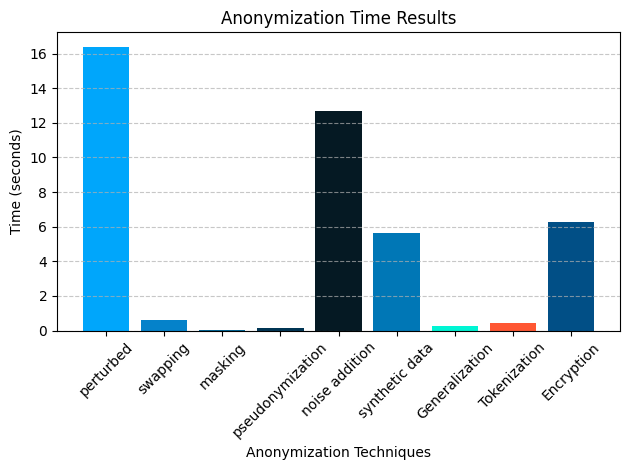

In [ ]:
anonymization_times = {
    "perturbed": perturbed_time,
    "swapping": swapped_time,
    "masking": masking_time,  # Adjusted key
    "pseudonymization": pseudonymization_time,
    "noise addition": noise_addition_time,
    "synthetic data": synthetic_time,
    "Generalization": generalization_time,
    "Tokenization": tokenization_time,
    "Encryption": encryption_time
}
print(anonymization_times.values())
# Use a different color for "synthetic data"
colors = ['#00A6FB', '#0582CA', '#006494', '#003554', '#051923', '#0077b6', '#00F5D4', '#FF5733', '#014F86', '#2EC4B6']

plt.bar(anonymization_times.keys(), anonymization_times.values(), color=colors, linewidth=2)
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Time (seconds)')
plt.xlabel('Anonymization Techniques')
plt.title('Anonymization Time Results')
plt.tight_layout()  # Adjust layout for better display
plt.savefig('/content/drive/MyDrive/data-anonymization/plots/time-plot.png')


<br><br>
<br><br>
<br><br>
<br><br>
<br><br>




```
# This is formatted as code
```



#### 3.Scalability Analysis

In [ ]:
ALGORITHMS = {
    'Time':{
              "perturbed": perturbed_time,
              "swapping": swapped_time,
              "masking": masking_time,  # Adjusted key
              "pseudonymization": pseudonymization_time,
              "noise addition": noise_addition_time,
              "synthetic data": synthetic_time,
              "Generalization": generalization_time,
              "Tokenization": tokenization_time,
              "Encryption": encryption_time
    },
    'Space':{
            "perturbation": perturbed_file_size,
            "swapping": swapped_file_size,
            "masking": masked_file_size ,
            "pseudonymization": pseudonymization_file_size,
            "noise addition": noise_addition_file_size,
            "synthetic data": synthetic_file_size,
            "Generalization" : generalization_file_size,
            "Tokenization": tokenization_file_size,
            "Encryption": encryption_file_size
    },
    'ease of use': {
            "perturbation": 4.5,
            "swapping": 4.5,
            "masking": 3.0,
            "pseudonymization": 2.0,
            "noise addition": 3.4,
            "synthetic data": 3.9,
            "Generalization" : 4.0,
            "Tokenization": 2.5,
            "Encryption": 3.5
    }
}

# Mock findings for each algorithm
algorithms = list(ALGORITHMS['Time'].keys())

#Space for each algorithm
space_required =   list(ALGORITHMS['Space'].values())# in MB

#Time taken for each algorithm
time_taken = list(ALGORITHMS['Time'].values())

#ease of use of each algorithm
ease_of_use = list(ALGORITHMS['ease of use'].values())  # on a scale of 1 to 5 (5 being the easiest)

# Preemptive analysis for a larger adjustable dataset as per user input in MBs
larger_data_size = 10

for algorithm in algorithms:
    # print(f"\nAnalysis for {algorithm} with Larger Dataset of {larger_data_size} MB:")
    # Assuming space required scales linearly with data size
    space_required_larger_data = space_required[algorithms.index(algorithm)] * (larger_data_size)

    # Assuming time taken scales linearly with data size
    time_taken_larger_data = time_taken[algorithms.index(algorithm)] * (larger_data_size)

    append = {algorithm : space_required_larger_data, algorithm : time_taken_larger_data}

    # print(f"Space Required: {space_required_larger_data:.2f} MB")
    # print(f"Time Taken: {time_taken_larger_data:.2f} seconds")
    # print(f"Ease of Use: {ease_of_use[algorithms.index(algorithm)]}")